In [350]:
## Imports
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import math

In [351]:
import pandas as pd
from sqlalchemy import create_engine

engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient_original = pd.read_sql('select * from patient', con=con)
df_patient = pd.read_sql('select * from patient', con=con)
df_pcr = pd.read_sql('select * from test', con=con)
con.close()



# df_pcr

Regardons tout d'abord la base de données df_pcr.

In [352]:
print("Shape of df_pcr: ", df_pcr.shape)
print("Types of different columns: \n", df_pcr.dtypes)
df_pcr.head()

Shape of df_pcr:  (8800, 2)
Types of different columns: 
 patient_id     int64
pcr           object
dtype: object


,patient_id,pcr
0,653091,N
1,347667,Negative
2,708481,Positive
3,148825,Negative
4,150081,Negative


On a donc 8800 lignes et deux colonnes, une avec patient_id et l'autre avec le résultat de PCR. Regardons s'il manque des données.

In [353]:
na_per_feature = {}
for feature in df_pcr.columns:
    nb_na = len(df_pcr[df_pcr[feature].isna()])
    na_per_feature[feature] = nb_na
    print("{0:15}   {1}".format(feature,f'{nb_na/len(df_patient)*100:.2f}'+"%"))
    
print(na_per_feature)

patient_id        0.00%
pcr               0.00%
{'patient_id': 0, 'pcr': 0}


Apparemment, il n'y a pas de NaN dans les données. Voyons ce qu'il y a dans les résultats de PCR.

In [354]:
df_pcr.pcr.unique()

array(['N', 'Negative', 'Positive', 'P'], dtype=object)

On a 4 valeurs possibles pour le résultat de PCR. On peut remplacer 'N' par 'Negative' et 'P' par 'Positive' pour avoir des valeurs cohérentes entre elles.

In [355]:
df_pcr = df_pcr.replace({"pcr": {'N':"Negative", 'P':"Positive"}})

In [356]:
df_pcr.pcr.unique()

array(['Negative', 'Positive'], dtype=object)

On regarde ensuite la colonne patient_id, qui ne devrait pas contenir de doublons.

In [357]:
pcr_id_duplicated = df_pcr.duplicated(subset="patient_id", keep=False)
print(pcr_id_duplicated[pcr_id_duplicated==True].shape)

(70,)


Il y a donc 70 patient_id concernés par des problèmes de doublons. On peut commencer par supprimer les doublons de df_pcr (même patient_id et même résultat de PCR), puis recommencer cette étape.

In [358]:
pcr_unique = df_pcr.drop_duplicates(inplace=False)
print(pcr_unique.shape)
pcr_all_duplicated = pcr_unique.duplicated(subset="patient_id", keep=False)
print(pcr_all_duplicated[pcr_all_duplicated==True].shape)

(8779, 2)
(28,)


On a donc 28 lignes avec un résultat de PCR différent pour un même patient_id. On ne peut pas décider de quel résultat de PCR est le bon, il y a deux options, soit supprimer ces lignes du dataset, soit les garder en gardant le ratio de tests positifs/tests négatifs ou en prenant un résultat au hasard. Il se pourrait qu'il y ait une autre variable qui entre en compte dans la distribution des résultats de PCR (par exemple l'âge), on va donc supprimer ces lignes.

In [359]:
df_pcr.drop_duplicates(inplace=True)
df_pcr.drop_duplicates(subset="patient_id", keep=False, inplace=True)
df_pcr.to_csv("clean_pcr.csv")
df_pcr.shape

(8751, 2)

# df_patient

On peut maintenant regarder un aperçu ce qu'il y a dans la base de données df_patient:

In [360]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
0,221958,matisse,clarke,13.0,rene street,ellenbrook,2527,wa,19710708.0,32.0,08 86018809,westella
1,771155,joshua,elrick,23.0,andrea place,east preston,2074,nsw,19120921.0,34.0,02 97793152,foxdown
2,231932,alice,conboy,35.0,mountain circuit,prospect,2305,nsw,19810905.0,22.0,02 20403934,None
3,465838,sienna,craswell,39.0,cumberlegeicrescent,henty,3620,wa,19840809.0,30.0,02 62832318,jodane
4,359178,joshua,bastiaans,144.0,lowrie street,campbell town,4051,nsw,19340430.0,31.0,03 69359594,None


In [361]:
print(df_patient.shape)
df_patient.describe(include="all")

(20000, 12)


,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
count,20000.000000,19560,19575,19618.000000,19204,19788,19801,18010,1.798900e+04,16003.000000,19081,7893
unique,NaN,1171,4273,NaN,4326,2925,2021,102,NaN,NaN,17916,3460
top,NaN,emiily,white,NaN,paul coe crescent,toowoomba,4350,nsw,NaN,NaN,07 29162528,brentwood vlge
freq,NaN,373,539,NaN,57,167,96,6143,NaN,NaN,4,85
mean,553918.938750,NaN,NaN,98.812468,NaN,NaN,NaN,NaN,1.949638e+07,27.534337,NaN,NaN
std,260234.961111,NaN,NaN,2481.908686,NaN,NaN,NaN,NaN,2.926916e+05,7.807008,NaN,NaN
min,100005.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,1.290041e+07,0.000000,NaN,NaN
25%,330194.250000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,1.924113e+07,24.000000,NaN,NaN
50%,556327.500000,NaN,NaN,24.000000,NaN,NaN,NaN,NaN,1.950032e+07,29.000000,NaN,NaN
75%,779419.500000,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,1.975052e+07,33.000000,NaN,NaN


On a donc 20.000 lignes dans cette DB, et 12 colonnes. Il y a beaucoup de NaN sur la ligne "unique" (il n'y a pas de unique pour les nombres), on peut donc se douter du type des différentes colonnes mais regardons ça de plus près.

In [362]:
print(df_patient.dtypes)

patient_id         int64
given_name        object
surname           object
street_number    float64
address_1         object
suburb            object
postcode          object
state             object
date_of_birth    float64
age              float64
phone_number      object
address_2         object
dtype: object


Quelques types semblent pouvoir être améliorés, street number pourrait être un entier et date_of_birth devrait être une date plutôt qu'un float par exemple. Pour chacune des colonnes, nous regarderons ce qu'elle contient pour voir si on peut en effet changer le type des données. On peut déjà estimer la quantité de données manquantes pour chaque colonne.

In [363]:
na_per_feature = {}
for feature in df_patient.columns:
    nb_na = len(df_patient[df_patient[feature].isna()])
    na_per_feature[feature] = nb_na
    print("{0:15}   {1}".format(feature,f'{nb_na/len(df_patient)*100:.2f}'+"%"))
    

patient_id        0.00%
given_name        2.20%
surname           2.12%
street_number     1.91%
address_1         3.98%
suburb            1.06%
postcode          1.00%
state             9.95%
date_of_birth     10.05%
age               19.98%
phone_number      4.59%
address_2         60.54%


Il manque énormément de 2e adresses, ainsi que beaucoup d'états, de dates de naissance et d'âges. Ce sera à prendre en compte lors du choix de features pour trouver les doublons. 

## 1. patient_id

Regardons tout d'abord la quantité de données manquantes dans cette première colonne. (C'est un sanity check, on a vu plus haut qu'il y avait bien 20.000 données dans cette colonne)

In [364]:
len(df_patient[df_patient.patient_id.isna()])

0

C'est bon signe, tous les échantillons ont un patient_id associé. Pas besoin de vérifier si des lignes ont un patient_id vide (pas NaN mais " ", par exemple), puisque ce sont des entiers.

On s'attend à ce que les id des différents patient soient uniques, vérifions cela.

In [365]:
patient_id_dup = df_patient[df_patient.patient_id.duplicated(keep=False)]

In [366]:
patient_id_dup.shape

(403, 12)

Cela fait donc 403 rows concernés par des doublons de *patient_id*, on est loin de la clé unique. Voyons si on peut avoir une meilleure idée de ce qui se passe, peut-être que les id correspondent à des gens qui sont venus plusieurs fois.

In [367]:
patient_id_dup[patient_id_dup.patient_id == patient_id_dup.patient_id.iloc[0]]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
22,427069,mystique,white,85.0,herington street,east maitland,6000,qld,NaN,21.0,07 24234495,None
5697,427069,zack,turtur,17.0,denny sxreet,nedlands,2195,nsw,19391105.0,34.0,04 85338899,glen wilga


On peut voir en prenant ce premier exemple qu'un même patient_id peut correspondre à deux personnes complètement différentes.

Il y a vraiment des erreurs dans les patient_id, cet id ne correspond pas du tout à la même personne lors de ses deux utilisations. La question est, peut-on recouper ces informations avec celles des données de PCR, i.e. qu'y a-t-il dans df_pcr ?

Il semblerait qu'il soit impossible de recouper les informations s'il y a un doublon de patient_id qui ne correspond pas à la même personne (on ne sait pas si le résultat de PCR appartient à l'un ou à l'autre des patients). Il parait donc plus judicieux de les enlever de chaque table puisqu'on ne peut pas attribuer la valeur de PCR à un des patients correspondants, même si cela réduit notre quantité de données, on risquerait d'introduire des erreurs dans les statistiques calculées plus tard.

In [368]:
df_patient = df_patient[~df_patient.patient_id.isin(patient_id_dup.patient_id)]

In [369]:
df_patient.shape

(19597, 12)

Nous avons bien retiré les 403 lignes impliquées dans des doublons de patient_id.

## 2. given_name and surname

In [370]:
len(df_patient[df_patient.given_name.isna()])

429

Il y a 429 lignes pour lesquelles le prénom est manquant.

In [371]:
len(df_patient[df_patient.surname.isna()])

419

Il y a 419 lignes pour lesquelles le nom de famille est manquant. Y a-t-il des lignes pour lesquelles les deux informations sont absentes?

In [372]:
df_patient[df_patient.given_name.isna() & df_patient.surname.isna()]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
4598,340891,None,None,70.0,fawkner street,gorokan,3178,vic,19150429.0,24.0,07 49934506,llangollen
6663,211362,None,None,3.0,sternberg crescent,elsterneick,2502,nsw,19000422.0,32.0,03 96314344,None
10664,644475,None,None,22.0,john xxiii college,craigmore,5046,tas,19781105.0,31.0,None,None
18526,207001,None,None,20.0,kirkwood crescent,cooroy,3231,None,19960825.0,30.0,03 16641630,None


In [373]:
len(df_patient[df_patient.given_name.isna() | df_patient.surname.isna()])

844

Nous avons donc 844 lignes où soit le nom, soit le prénom, soit les deux sont manquants. La gestion de doublons pour ces lignes ne pourra pas s'appuyer uniquement sur les noms et prénoms, il sera donc important d'inclure d'autres données dans cette fonction.

In [374]:
df_patient[(df_patient.given_name=="") | (df_patient.surname=="")]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2


Il n'y a pas de nom ou prénom où la valeur associée est une chaîne de caractères vides, on peut remplacer les données manquantes par des chaînes de caractères vides.

In [375]:
df_patient[['given_name','surname']].fillna(value="", inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## 3. street_number

In [376]:
len(df_patient[df_patient.street_number.isna()])

374

Il y a 374 rows où la donnée street_number est manquante.

In [377]:
len(df_patient[df_patient.street_number<0])

0

Aucun numéro de rue n'est négatif, ils semblent donc cohérents pour l'instant.

In [378]:
len(df_patient[(df_patient.street_number * 10 % 10 != 0) | (df_patient.street_number.isna())])

374

Il semblerait que toutes les cellules soient des entiers, sauf celles où l'information n'est pas renseignée.

In [379]:
len(df_patient[df_patient.street_number==0])

6

Certaines adresses ont pour numéro de rue '0'. Curieux, mais cela ne deviendra donc pas notre valeur par défaut pour les rows où cette information n'est pas fournie. On y met -1, pour pouvoir récupérer plus tard les adresses où le numéro était manquant.

In [380]:
df_patient.street_number.fillna(-1, inplace=True)

On peut maintenant sereinement changer le type de cette colonne.

In [381]:
df_patient['street_number'] = np.int64(df_patient['street_number'])
print(df_patient.dtypes)

patient_id         int64
given_name        object
surname           object
street_number      int64
address_1         object
suburb            object
postcode          object
state             object
date_of_birth    float64
age              float64
phone_number      object
address_2         object
dtype: object


Regardons maintenant s'il y a des données incohérentes.

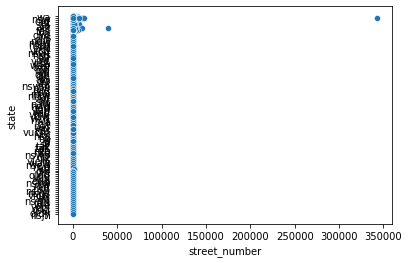

In [382]:
sns.scatterplot(data=df_patient, x="street_number", y="state")

Il semblerait qu'il y ait des valeurs incohérentes dans les numéros de rue (on peut avoir de grandes rues, mais pas aussi longues).

In [383]:
median_street_number = df_patient.street_number.median(axis=0)
print("Median street number:", median_street_number)
std_street_number = df_patient.street_number.std(axis=0)

Median street number: 24.0


In [384]:
df_patient[df_patient.street_number > median_street_number + 5*std_street_number]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
7055,869217,nicholas,fitzpatrick,342951,taylor place,normanhurst,4560,nsw,19680530.0,13.0,08 37654995,None
12440,446997,jessica,matthews,39430,airey crescent,plumpton,3173,vic,19331014.0,29.0,02 15333991,summer hill
18456,232871,None,britten,12569,streeton drive,bowenvale,3162,nsw,19730215.0,NaN,04 25029200,sanctuary vlge


Il y a bien des numéros de rue qui semblent incohérents, cependant nous ne changerons rien aux numéros de rue, il est compliqué de les corriger et cela ne devrait pas changer de beaucoup le fuzzy matching.

## 4. address_1 et address_2

In [385]:
print(len(df_patient[df_patient.address_1.isna()]), len(df_patient[df_patient.address_2.isna()]))

781 11872


Cela fait 781 lignes où l'adresse 1 est manquante, et beaucoup plus pour l'adresse 2. Il est possible que certains doublons ne soient pas trouvés dû à l'absence d'adresse pour certains échantillons. Voyons s'il y a des adresses incohérentes (chiffres, caractères spéciaux,...).

In [386]:
df_patient[df_patient.address_1==""]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2


In [387]:
df_patient[df_patient.address_2==""]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2


On peut en dire qu'il n'y a aucune adresse vide. Remplaçons donc les NaN par des chaînes de caractères vides.

In [388]:
df_patient.address_1.fillna("", inplace=True)
df_patient.address_1.fillna("", inplace=True)

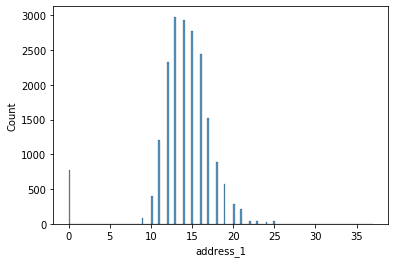

In [389]:
sns.histplot(df_patient.address_1.apply(len))

In [390]:
len(df_patient[df_patient.address_1.apply(len)==0])

781

Ce pic d'adresses de longueur 0 correspond bien aux adresses manquantes que nous avons remplacées par des chaînes de caractères vides. Voyons si certaines adresses sont composées de chiffres ou d'autres caractères.

In [391]:
def include_digit(input_str: str) -> bool:
    return any(char.isdigit() for char in input_str)

df_patient[df_patient.address_1.apply(include_digit)]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2
1322,313942,joe,reimef,68,home 186,windsor,7019,nsw,19581213.0,26.0,04 22861452,kiewa street
3763,186516,hannah,clarke,6,villa 3,brighton-le-sands,3996,qln,19730115.0,NaN,07 53595738,chandler street


Certaines adresses contiennent bien des numéros, mais qui semblent être des précisions d'adresse.

In [392]:
def include_special_character(input_str: str) -> bool:
    return (all(not(char.isalpha() or char==" ") for char in input_str) and len(input_str)!=0)

len(df_patient[df_patient.address_1.apply(include_special_character)])

0

On a bien vérifié qu'il n'y avait pas de caractères spéciaux dans la colonne address_1.

## 5. suburb, postcode and state

On commence par vérifier les données manquantes, puis on regardera s'il y a des incohérences, par exemple des codes postaux qui ne correspondent pas à l'état.

In [393]:
len(df_patient[df_patient.suburb.isna()])

203

In [394]:
len(df_patient[df_patient.postcode.isna()])

194

In [395]:
len(df_patient[df_patient.state.isna()])

1950

In [396]:
len(df_patient.state.unique())

102

Il y a 6 états en Australie d'après Wikipédia (https://fr.wikipedia.org/wiki/États_et_territoires_de_l%27Australie), (sa, wa, nsw, qld, tas et vic), et 3 territoires intérieurs (nt, act, jbt). Cependant il y a 102 valeurs différentes pour les états dans la bdd, il doit y avoir des erreurs. Récupérons les 9 valeurs de la colonne state qui reviennent le plus souvent.

In [397]:
df_patient.groupby("state").size().sort_values(ascending=False).head(9)

state
nsw    6030
vic    4246
qld    3456
wa     1553
sa     1362
tas     495
act     242
nt      127
nss       7
dtype: int64

On récupère bel et bien les différents états donnés par cette source externe, cependant le territoires jbt ne semble pas (ou peu) apparaître. Regardons combien il y a de lignes avec un état différent de ces 9 états et territoires.

In [398]:
states_territories = ["nsw", "vic", "qld", "wa", "sa", "tas", "act", "nt"]
len(df_patient[~(df_patient.state.isin(states_territories) | df_patient.state.isna())])

136

Il y a au moins deux façons de corriger ces valeurs, 1. en faisant un matching avec les valeurs qui existent réellement, et 2. en comparant avec le code postal et la valeur de suburb. On choisit la première méthode, en faisant un matching entre chaque entrée non conforme et son voisin le plus proche dans les 9 valeurs que nous connaissons comme vraies (avec une base de données regroupant code postal et état, nous pourrions remplir et les états mal orthographiés, et les états manquants (si le code postal est présent).


In [399]:
# function allowing for the package python-Levenshtein not to be necessary 
# for likeness computation between two strings

def better_scorer(s1: str, s2: str) -> int:
    fuzz_ratio = fuzz.ratio(s1, s2)
    fuzz_ratio -= (s2.find(s1)*5)
    return fuzz_ratio

def correct_state(state_input: str, states_territories: list = states_territories) -> str:
    if state_input is None:
        return ""
    return(process.extractOne(state_input, states_territories, scorer=better_scorer)[0])
    
    
df_patient["state_corrected"] = df_patient.apply(lambda row: correct_state(row.state), axis = 1)

df_patient[(df_patient.state != df_patient.state_corrected) & (~df_patient.state.isna())].head(5)



,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected
301,577095,joshua,bellamly,41,namatjiracdrive,clayfield,4574,vc,19631211.0,10.0,03 61524567,None,vic
364,412252,jettie,dixon,9,,cooranbong,2795,qkd,19090316.0,31.0,None,None,qld
377,956703,amelia,webb,6,oxley street,thornbury,2350,s,19900717.0,40.0,08 65367239,None,sa
407,730271,jessica,browne,1,archdall street,round corner,5333,qlh,19750207.0,NaN,02 79191395,None,qld
791,186188,emiil,white,23,poynton street,ardeer,5118,ndw,19091110.0,7.0,07 37600084,brentwood vlge,nsw



Il serait intéressant de corriger ces valeurs grâce au code postal donné. Il y a toujours une possibilité que le code postal soit lui aussi faux, mais on peut le supposer vrai pour les données manquantes, et vérifier la cohérence pour les données présentes. Mes connaissances en géographie australienne s'arrêtant là, il serait nécessaire d'intégrer une nouvelle base de données à notre projet, celle des (suburbs, postcodes et states) d'Australie.

In [400]:
df_patient[(df_patient.state.isna()) & (df_patient.postcode.isna())]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected
214,237848,amaya,clisby,175,rutherford crescent,downer,None,None,19531215.0,8.0,07 19639912,boxwood hill,
859,109337,gianni,papageorgiou,20,hobbs street,wagaman,None,None,19211005.0,12.0,03 98411510,brambletye vinyard,
2809,367926,dylan,drysdale,4,fawkner street,kings cross,None,None,19391203.0,28.0,02 23269087,dickson family practice,
6716,988698,bailey,vincent,16,wylly place,lake illawarra,None,None,19451103.0,31.0,07 81676543,riverland village,
7917,345282,isobel,white,12,mckinley circuit,elwood,None,None,19170406.0,NaN,07 13732931,brentwood vlge,
8885,816825,jack,lissner,40,luehmann street,greenacre,None,None,19950323.0,39.0,07 42474648,None,
11021,847097,brendan,mccaffrey,29,adamson crescent,salisbury,None,None,NaN,NaN,None,None,
11419,487902,stephanie,kusnezow,12,murchison street,northmead,None,None,19890630.0,27.0,04 79036574,dandarriga,
11997,248395,georgia,beal,23,clements street,yarrawonga,None,None,19760421.0,42.0,08 24303408,None,
12877,379302,fiona,swayne,25,currie crescent,lower templestowe,None,None,19421013.0,26.0,03 52918979,None,


Cette information (état) resterait indisponible pour les lignes ci-dessus.

## 6. date_of_birth and age

First, let's change the type of date_of_birth to an actual date.

In [401]:
df_patient["dob_date"] = df_patient.apply(lambda row: str(row.date_of_birth)[:-2] if not math.isnan(row.date_of_birth) else "", axis=1)

# function to convert a string into date format
def to_valid_date(input_str: str, format: str="%Y%m%d"):
    try:
        return(pd.to_datetime(input_str, format="%Y%m%d"))
    except ValueError:
        return(None)
    
df_patient["dob_date"] = df_patient.apply(lambda row: to_valid_date(row.dob_date) if len(row.dob_date)!=0 else None, axis=1)

print(len(df_patient[(df_patient.date_of_birth.notna()) & (df_patient.dob_date.isna())]))



174


Il y a 174 dates de naissance dont la valeur est invalide, en dehors des dates non renseignées (mois ou jour inexistant, jour inexistant dans le mois donné, etc).

In [402]:
from dateutil.relativedelta import relativedelta
df_patient["test_year"] = df_patient.apply(lambda row: row.dob_date.year + row.age, axis=1)

df_patient[df_patient.dob_date.isna()]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected,dob_date,test_year
15,378167,cain,scarles,58,reader court,dorrigo,2428,qld,NaN,31.0,03 67476384,jorobe,qld,NaT,NaN
17,429365,None,coffey,1409,musson close,beaconsfield upper,5019,wa,NaN,30.0,03 13369308,silverweir,wa,NaT,NaN
29,284779,alexandra,miles,23,duffy street,christies beach,2047,nsw,NaN,29.0,02 24131074,riverland village,nsw,NaT,NaN
34,600186,zachary,stancliffe,40,macgregor street,coodanup,6027,nsw,NaN,29.0,03 67952046,woodsong,nsw,NaT,NaN
40,627035,ellorah,parr,12,bosworth circuit,ardeer,3523,sa,19030539.0,36.0,08 40688028,killune,sa,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19968,902251,caleb,richmond,4,philp place,elimbah,4873,vic,NaN,NaN,03 73275720,None,vic,NaT,NaN
19975,752160,ashleigh,None,30,winser crescent,buff point,4806,wa,NaN,36.0,04 10236954,glennhill,wa,NaT,NaN
19984,134889,xavier,priest,28,needham place,reynella,3318,nsw,NaN,NaN,02 74580410,None,nsw,NaT,NaN
19994,912344,fraser,mcneill,10,collie street,booragul,2075,qld,NaN,31.0,02 77020191,None,qld,NaT,NaN


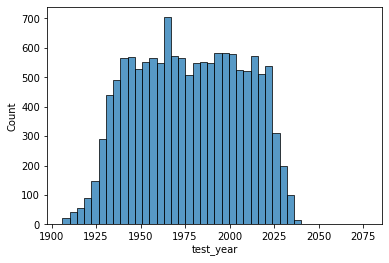

In [403]:
sns.histplot(data=df_patient, x="test_year")

On voit qu'en additionnant les années de naissance avec l'âge des gens, on trouve des dates allant des années 1900 à 2075 ce qui devrait être l'année où le test a été réalisé. Sachant que ce sont des données Covid, on peut supposer que soit les dates de naissance sont fausses, soit ce sont les âges. Quoi qu'il en soit, les valeurs de chaque sont compromises.

In [404]:
len(df_patient[df_patient.dob_date.isna()])

2149

In [405]:
len(df_patient[df_patient.age.isna()])

3916

On devrait pouvoir être capables d'utiliser les âges pour récupérer une estimation dates de naissance manquantes et vice versa (si les tests ont été réalisés sur un laps de temps réduit, les deux valeurs devraient être corrélées).

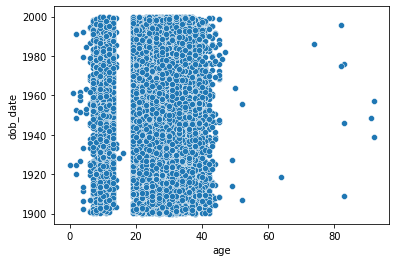

In [406]:
sns.scatterplot(data=df_patient, x="age", y="dob_date")

Il semblerait d'une part que contre-intuitivement, l'âge soit indépendant de la date de naissance (si on suppose que les tests ont été faits sur une même année, ou dans uné période rapprochée). De plus, il semble y avoir au moins deux groupes d'âges distincts, regardons cela de plus près.

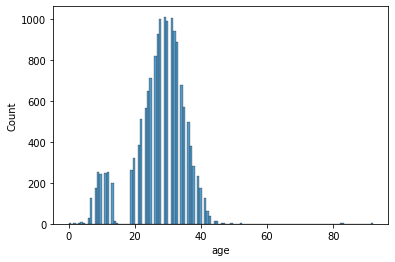

In [407]:
sns.histplot(data=df_patient, x = "age")

Ceci confirme les deux groupes d'âges. 

In [408]:
from sklearn.mixture import GaussianMixture

to_fit = np.array(df_patient[~df_patient["age"].isna()].age).reshape(-1, 1)
gmm_age = GaussianMixture(2).fit(to_fit)

print(gmm_age.means_)


[[29.41756349]
 [10.04355269]]


La moyenne du premier groupe est de 10 ans, et la moyenne du deuxième groupe est de 29 ans. Il semble y avoir une netter séparation entre les deux groupes, on peut aussi les diviser manuellement.

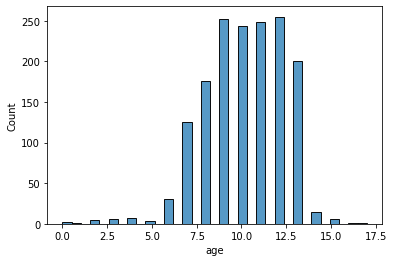

In [409]:
sns.histplot(data=df_patient[df_patient.age<18], x = "age")

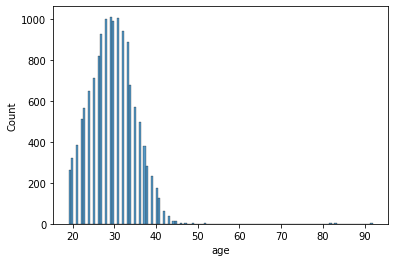

In [410]:
sns.histplot(data=df_patient[df_patient.age>18], x = "age")

In [411]:
mean_younger = df_patient[df_patient.age<=18].age.mean()
mean_older = df_patient[df_patient.age>18].age.mean()
mean_all = df_patient.age.mean()

print("Means", mean_younger, mean_older, mean_all)

Means 10.12040557667934 29.47486350421896 27.52719852050252


On retrouve les moyennes calculées précédemment avec des gaussiennes. 

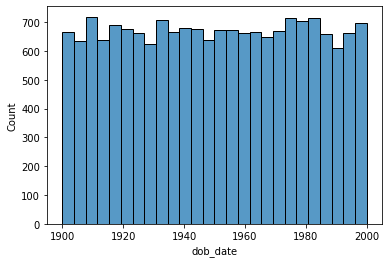

In [412]:
sns.histplot(data=df_patient, x="dob_date")

On peut mieux approximer les âges probables que les années de naissance. En ce qui concerne les données manquantes d'âge, on peut les remplacer par des tirages aléatoires de la gaussian mixture calculée plus haut. On utilisera l'âge plutôt que les dates de naissance (qui ne semblent pas cohérentes) pour une analyse plus poussée des résultats, mais on peut retenir les dates de naissance pour repérer les doublons.

In [413]:
df_patient["age_inferred"] = df_patient.apply(lambda row: gmm_age.sample()[0][0][0] if (math.isnan(row.age)) else row.age, axis = 1)

In [414]:
df_patient[(df_patient.age_inferred.notna() & df_patient.age.isna())].head()

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected,dob_date,test_year,age_inferred
14,291335,mikayla,paterson,20,freda bennett circuit,dover heights,4670,qld,19810810.0,NaN,08 88377793,None,qld,1981-08-10,NaN,24.504916
18,164820,lia,wilde,30,elsey street,None,3109,qld,19070704.0,NaN,03 98048163,None,qld,1907-07-04,NaN,31.831707
30,447449,andrew,fimmano,83,,clifton springs,2560,nsw,19871005.0,NaN,02 39509342,None,nsw,1987-10-05,NaN,28.862277
32,358795,riley,mildren,20,jinka street,kempsey,3111,vic,19181231.0,NaN,None,None,vic,1918-12-31,NaN,25.255982
33,586232,jade,green,19,goyder street,coolum beach,4211,sa,19471129.0,NaN,02 22915798,None,sa,1947-11-29,NaN,34.624115


## 7. phone_number

En regardant les quelques premières lignes de la base de données, on se rend compte que les numéros de téléphone australiens commencent par deux chiffres suivis d'un espace puis huit autres chiffres. Regardons les données manquantes ainsi que les données ne respectant pas ce schéma.

In [415]:
len(df_patient[df_patient.phone_number.isna()])

903

In [416]:
#df_patient[~((df_patient.phone_number.isna()) | (df_patient.phone_number.apply(len)==11))]

no_missing_phone_numbers = df_patient[df_patient.phone_number.notna()]
no_missing_phone_numbers[no_missing_phone_numbers.phone_number.apply(len) !=11]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected,dob_date,test_year,age_inferred


In [417]:
import re

phone_match = re.compile("^[0-9]{2} [0-9]{8}$")
#df_patient["phone_format"] = df_patient.apply(lambda row: print(row.attrs), axis=1)
df_patient["phone_format"] = df_patient.apply(lambda row: True if phone_match.match(str(row.phone_number)) else False, axis=1)

df_patient[(~df_patient.phone_format) & (~df_patient.phone_number.isna())]

,patient_id,given_name,surname,street_number,address_1,suburb,postcode,state,date_of_birth,age,phone_number,address_2,state_corrected,dob_date,test_year,age_inferred,phone_format


On peut en déduire que tous les numéros de téléphone entrés ont le bon format. Selon Wikipedia encore une fois, chaque état a son indicateur téléphonique, voyons si c'est le cas ici.

In [418]:
df_patient["phone_geo"] = df_patient.apply(lambda row: str(row.phone_number)[:2] if row.phone_number else None, axis=1)

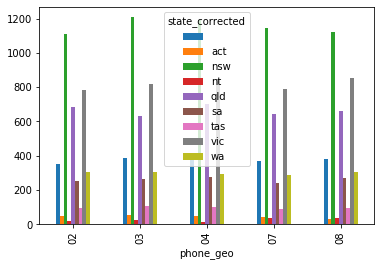

In [419]:
pd.crosstab(df_patient['phone_geo'],df_patient['state_corrected']).plot.bar()

Apparemment, dans ce dataset, on ne peut pas faire de lien entre le numéro de téléphone et l'état qui semblent indépendants, on ne peut donc pas vérifier la cohérence des numéros donnés.

## Nettoyage

Finalement, réarrangeons les colonnes pour que leur ordre ait un sens et qu'il soit plus naturel de naviguer dans cette table.

In [420]:
df_patient = df_patient[['patient_id', 'given_name', 'surname', 'street_number', 'address_1', 'address_2', 'suburb', 'postcode', 'state', 'state_corrected', 'date_of_birth', 'dob_date', 'age', 'age_inferred', 'test_year', 'phone_number', 'phone_format', 'phone_geo']] 

In [421]:
df_patient.head()

,patient_id,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,state_corrected,date_of_birth,dob_date,age,age_inferred,test_year,phone_number,phone_format,phone_geo
0,221958,matisse,clarke,13,rene street,westella,ellenbrook,2527,wa,wa,19710708.0,1971-07-08,32.0,32.0,2003.0,08 86018809,True,08
1,771155,joshua,elrick,23,andrea place,foxdown,east preston,2074,nsw,nsw,19120921.0,1912-09-21,34.0,34.0,1946.0,02 97793152,True,02
2,231932,alice,conboy,35,mountain circuit,None,prospect,2305,nsw,nsw,19810905.0,1981-09-05,22.0,22.0,2003.0,02 20403934,True,02
3,465838,sienna,craswell,39,cumberlegeicrescent,jodane,henty,3620,wa,wa,19840809.0,1984-08-09,30.0,30.0,2014.0,02 62832318,True,02
4,359178,joshua,bastiaans,144,lowrie street,None,campbell town,4051,nsw,nsw,19340430.0,1934-04-30,31.0,31.0,1965.0,03 69359594,True,03


In [422]:
df_patient.to_csv("db_clean.csv")

In [423]:
#df_patient.groupby("age").aggregate({"patient_id":"count"})